# Formulação do Problema da Arbitragem das Apostas como um problema de programação linear

\\[
\begin{align*}
\text{CA} &= \sum_{i=1}^{n} \frac{1}{O_i} \\
\text{Arbitrar(CA)} &= 
    \begin{cases}
      1, & \text{se } \text{CA} < 1 \\
      0, & \text{se } \text{CA} \geq 1
    \end{cases} \\
\text{Z} &= \max \left( \text{Arbitrar(CA)} \cdot \frac{1}{\text{CA}} \cdot \sum_{i=1}^{n} X_i \right) \\
\text{Sujeito a:} \\
& \sum_{i=1}^{n} X_i \leq M \\
& O_1 X_1 = O_2 X_2 = \cdots = O_n X_n
\end{align*}
\\]

O problema acima pode ser modelado como um simples sistema linear, da forma matricial

\\[
\begin{bmatrix}
    1 & 0 & \cdots & -\frac{O_n}{O_1}  \\
    0 & 1 & \cdots & -\frac{O_n}{O_2}  \\
    \vdots & \vdots & \cdots & \vdots  \\
    1 & 1 & \cdots & 1
\end{bmatrix}
\begin{bmatrix}
    X_1 \\
    X_2 \\
    \vdots \\
    X_n
\end{bmatrix}
=
\begin{bmatrix}
    0 \\
    0 \\
    \vdots \\
    M
\end{bmatrix}
\\]

Se considerarmos que utilizaremos todo o montante disponível para realização das apostas e isto, é desejável no caso do problema em sua versão contínua, pois, na existência de condição de arbitragem, o retorno será máximo (não obstante qual cenário disjunto ocorra) se e somente se todo montante disponível para apostas for aplicado.

A solução deste sistema, calcula as quantidades \\(X_i\\) a serem apostadas para maximizar o retorno desejado e é dada para cada \\(X_i\\) como:

\\[
X_i = \dfrac{M}{O_i \left( \displaystyle\sum_{j=1}^{n} \dfrac{1}{O_j} \right)} = \frac{M}{O_i \cdot CA}, \quad \text{para } i = 1, 2, \ldots, n
\\]

Considerando agora, com restrições de integralidade, que para cada X_i devemos testar seus valores de piso e de teto em combinação com os valores subsequentes e construir o espaço de todas os candidatos possíveis, logo temos que a partir do produto cartesiano de todos os valores possíveis que \\(X_i\\) possa assumir (piso e teto) para todo i, construímos o conjunto de candidatos:

\\[
S = \prod_{i = 1}^{n}\{ \lfloor x_i \rfloor,\ \lceil x_i \rceil \}
\\]

Em python:

In [ ]:
import itertools
from functools import reduce
import math

M = 100
odds = [3.12, 2.99, 3]
CA = sum(map(lambda x: 1/x, odds))
X = [M/(odd * CA) for odd in odds]

C = [
    tuple(0 for x in X)
] +\
list(
    itertools.product(*[
        [math.floor(x), math.ceil(x)] for x in X
    ])
)

arbitrar = lambda CA: 1 if CA < 1 else 0
o_i_x_i_gt_Z_x_forall_i = lambda odds, X: reduce(
    lambda a, b: a and b,
    [ odd * x > sum(X) for odd, x in zip(odds, X) ]
)
Z = lambda x: arbitrar(CA) * 1/CA * sum(x)

Para obtermos a melhor solução do problema com restrições de integralidade, dada a existência de um conjunto C com todas as combinações possíveis de valores para uma solução, basta portanto executar o seguinte procedimento:

1. Atribuir à variável maior o valor de menos infinito
2. Para cada \\(c \in C\\)
    1. Verificar se \\(\sum_{i = 1}^{n} {c_i} \leq M\\), se \\(Z(c) > \text{maior}\\) e se \\(O_i \cdot c_i \gt \sum_{i = 1}^{n}{c_i}, \ \forall i\\) (esta ultima condição para verificar que o retorno em qualquer evento é maior que o total apostado)
        - Se sim, atualizar a solucao para c e atualizar maior para Z(c)

In [ ]:
maior = float('-inf')
solucao = None
for c in C:
    if sum(c) <= M and Z(c) > maior and o_i_x_i_gt_Z_x_forall_i(odds, c):
        solucao = c
        maior = Z(c)
solucao

Este é um exemplo para 3 apostas, mas, vamos generalizar para vários eventos disjuntos e comparar os gráficos de tempo de exeução para obtenção das soluções sem restrições de integralidade e com restrições de integralidade para verificação do crescimento exponencial.

In [1]:
import itertools
from functools import reduce
import math
import random
import time
import numpy as np

def generate_odds(numero_de_variaveis):
    while True:
        odds = [random.uniform(1 + 0.5 * numero_de_variaveis,  (np.log10(numero_de_variaveis) + 1) * numero_de_variaveis) for _ in range(numero_de_variaveis)]
        # gerar odds que produzam condicao de arbitragem entre 0.2 e 0.99
        if 0.2 < sum(1 / odd for odd in odds) < 0.99:
            return odds

arbitrar = lambda CA: 1 if CA < 1 else 0
Z = lambda CA, X: arbitrar(CA) * 1/CA * sum(X)
o_i_x_i_gt_Z_x_forall_i = lambda odds, X: reduce(
    lambda a, b: a and b,
    [ odd * x > sum(X) for odd, x in zip(odds, X) ]
)

def arbitrage_without_integer_constraints(odds, M):
    CA = sum(map(lambda odd: 1/odd, odds))
    X = [M/(odd * CA) for odd in odds] if arbitrar(CA) else\
        [0 for odd in odds]
    return Z(CA, X), X
    
def arbitrage_with_integer_constraints(odds, M, X = None):
    ''' 
        X is the n-array containing the default Real solution which
        should span all 2^n + 1 integer combinations from its own values
    '''
    if not X:
        optimum, X = arbitrage_without_integer_constraints(odds, M)
        if optimum == 0: # if there's no arbitrage, we should not bet nothing
            return optimum, X
        
    C = [
        tuple(0 for x in X) # C should contain null element as we need at least one solution
    ] +\
    list(
        itertools.product(*[
            [math.floor(x), math.ceil(x)] for x in X
        ])
    )
    # 
    greatest = float('-inf')
    solution = C[0] # ao menos o elemento nulo soluciona o problema
    CA = sum(map(lambda odd: 1/odd, odds))
    for c in C:
        if sum(c) <= M and Z(CA, c) > greatest and o_i_x_i_gt_Z_x_forall_i(odds, c):
            solution = c
            greatest = Z(CA, c)
    # ao fim, a solucao encontrada estará em solution
    # portanto, retornamos:
    return Z(CA, solution), solution

# até 32 variáveis teremos 4 bilhoes - 2^32 - solucoes possiveis o que ainda pode ser alcançado
# por um processador doméstico de 2Ghz
# estimando por alto, 32 operacoes de multiplicacao + 32 somas + 3 * 32 comparacoes repetidas 4
# bilhoes de vezes dão algo próximo a 400 bilhões de operações. Se o processador é capaz de efetuar
# 2 bilhões de operações por segundo, com 32 variáveis gastaríamos algo próximo a 200s, apesar de acreditar
# que muito mais tempo será gasto.

numero_de_variaveis = [ i for i in range(2, 16) ]

# pretendemos fazer um comparativo dos tempos de cada versão (real e inteira) para mostrar nos gráficos

def simular(numeros_de_variaveis = []):
    tempos = {
        'com_restricoes_de_integralidade': {},
        'sem_restricoes_de_integralidade': {}
    }
    for n in numeros_de_variaveis:
        M = 100 if n <= 5 else\
            np.round(
                n * 10 ** (np.ceil(np.log10(n)) + 2)
            )
        odds = generate_odds(n)
        # obtencao da solucao sem restricoes de integralidade
        start = time.time()
        _, X_prime = arbitrage_without_integer_constraints(odds, M)
        tempos['sem_restricoes_de_integralidade'][n] = time.time() - start
        # obtencao de solucao com restricoes de integralidade
        start = time.time()
        _, X_prime_integer = arbitrage_with_integer_constraints(odds, M, X = X_prime)
        tempos['com_restricoes_de_integralidade'][n] = time.time() - start
    return tempos
tempos = simular([ i for i in range(2, 24) ])

# Mostrando a diferença dos tempos de execução com e sem restrições de integralidade

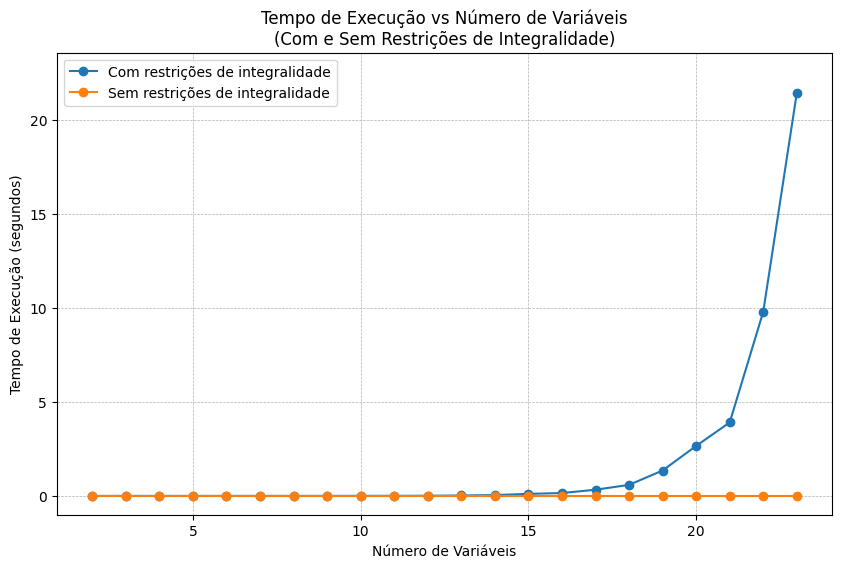

In [5]:
import matplotlib.pyplot as plt

# Organizando os dados
x = list(tempos['com_restricoes_de_integralidade'].keys())
y_com_restricoes = list(tempos['com_restricoes_de_integralidade'].values())
y_sem_restricoes = list(tempos['sem_restricoes_de_integralidade'].values())
# Criando o gráfico
plt.figure(figsize=(10, 6))
plt.plot(x, y_com_restricoes, label='Com restrições de integralidade', marker='o')
plt.plot(x, y_sem_restricoes, label='Sem restrições de integralidade', marker='o')

# Configurações do gráfico
#plt.yscale('log')  # Usando escala logarítmica no eixo y para melhor visualização
plt.ylim(-1, max(y_com_restricoes) * 1.1)
plt.xlabel('Número de Variáveis')
plt.ylabel('Tempo de Execução (segundos)')
plt.title('Tempo de Execução vs Número de Variáveis\n(Com e Sem Restrições de Integralidade)')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Exibindo o gráfico
plt.show()

Observamos que os experimentos realizados comprovam as estimativas de custo computacional não polinomial da versão do problema com restrições de integralidade.